<a href="https://colab.research.google.com/github/springboardmentor54158a/AIDriven-Archaeological-Site-Mapping/blob/prabhakar/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:

!pip uninstall -y torch torchvision torchaudio opencv-python opencv-python-headless
!pip install torch==2.1.0 torchvision==0.16.0 torchaudio==2.1.0
!pip install opencv-python-headless==4.8.0.76
!pip install segmentation-models-pytorch albumentations --quiet


Found existing installation: opencv-python-headless 4.8.0.76
Uninstalling opencv-python-headless-4.8.0.76:
  Successfully uninstalled opencv-python-headless-4.8.0.76
ERROR: Could not find a version that satisfies the requirement torch==2.1.0 (from versions: 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.5.0, 2.5.1, 2.6.0, 2.7.0, 2.7.1, 2.8.0, 2.9.0, 2.9.1)
ERROR: No matching distribution found for torch==2.1.0
  Using cached opencv_python_headless-4.8.0.76-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
Using cached opencv_python_headless-4.8.0.76-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (49.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.24 requires opencv-python-headless>=4.9.0.80, but you have opencv-python-headless 4.8.0.76 which is incompatible.
albumentations 2.0.8 requires opencv-python-hea

In [5]:
!pip uninstall -y numpy opencv-python opencv-python-headless
!pip install numpy==1.26.4 opencv-python-headless==4.8.1.78


Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: opencv-python-headless 4.12.0.88
Uninstalling opencv-python-headless-4.12.0.88:
  Successfully uninstalled opencv-python-headless-4.12.0.88
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 118.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 19.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires opencv-python>=3.4.8.29, which is not installed.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
albucore 0.0.24 requires opencv-python-headless>=4.9.0.80, but you have opencv-python-headless 4.8.1.78 which is incompatible.
jaxlib 0.7.2 requires numpy>

In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt


In [2]:
class VegDataset(Dataset):
    def __init__(self, img_dir, mask_dir):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.images = sorted(os.listdir(img_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)
        mask_path = os.path.join(
            self.mask_dir, img_name.replace(".jpg", "_mask.png")
        )

        # Image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (512, 512))
        image = image / 255.0

        # Mask (color → class)
        mask_color = cv2.imread(mask_path)
        mask_color = cv2.resize(mask_color, (512, 512))

        mask = np.zeros((512, 512), dtype=np.uint8)

        green = (mask_color[:, :, 1] > 200) & (mask_color[:, :, 0] < 50)
        mask[green] = 1   # vegetation

        image = torch.tensor(image).permute(2, 0, 1).float()
        mask = torch.tensor(mask).long()

        return image, mask


In [3]:
train_dataset = VegDataset(
    "/content/dataset/images",
    "/content/dataset/masks"
)

train_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True
)


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=2   # background + vegetation
).to(device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [7]:
EPOCHS = 10

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{EPOCHS}] Loss: {epoch_loss/len(train_loader):.4f}")


Epoch [1/10] Loss: 1.0397
Epoch [2/10] Loss: 0.8152
Epoch [3/10] Loss: 0.6926
Epoch [4/10] Loss: 0.6328
Epoch [5/10] Loss: 0.6100
Epoch [6/10] Loss: 0.5940
Epoch [7/10] Loss: 0.5348
Epoch [8/10] Loss: 0.5049
Epoch [9/10] Loss: 0.4946
Epoch [10/10] Loss: 0.4699


In [8]:
def dice_score(pred, gt):
    pred = (pred == 1).astype(np.uint8)
    gt = (gt == 1).astype(np.uint8)
    intersection = (pred & gt).sum()
    return (2 * intersection) / (pred.sum() + gt.sum() + 1e-7)

def iou_score(pred, gt):
    pred = (pred == 1).astype(np.uint8)
    gt = (gt == 1).astype(np.uint8)
    intersection = (pred & gt).sum()
    union = (pred | gt).sum()
    return intersection / (union + 1e-7)


In [9]:
model.eval()

image, gt_mask = train_dataset[0]
image_tensor = image.unsqueeze(0).to(device)

with torch.no_grad():
    output = model(image_tensor)

pred_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()
gt_mask = gt_mask.numpy()

print("Dice:", round(dice_score(pred_mask, gt_mask), 4))
print("IoU :", round(iou_score(pred_mask, gt_mask), 4))


Dice: 0.7628
IoU : 0.6166


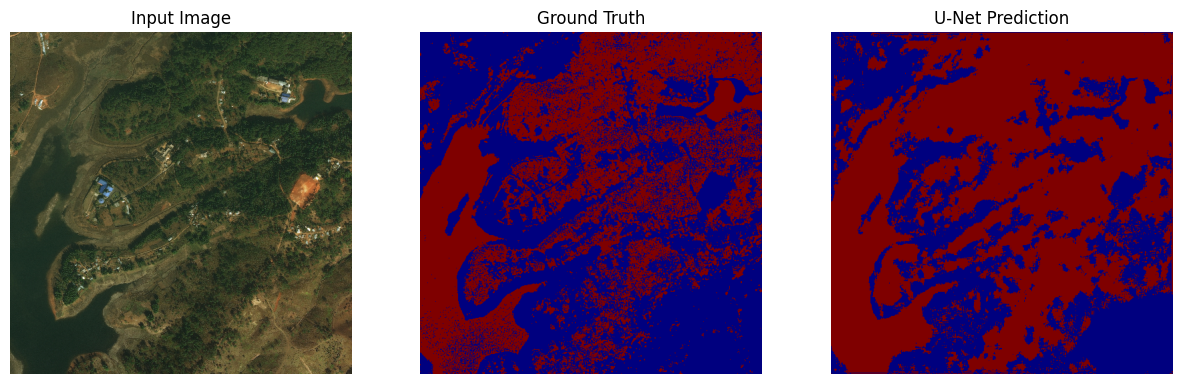

In [10]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title("Input Image")
plt.imshow(image.permute(1,2,0))
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Ground Truth")
plt.imshow(gt_mask, cmap="jet")
plt.axis("off")

plt.subplot(1,3,3)
plt.title("U-Net Prediction")
plt.imshow(pred_mask, cmap="jet")
plt.axis("off")

plt.show()
